## Import Packages and Data

In [172]:
#imports
%pip install simpletransformers
%pip install transformers datasets evaluate accelerate
%pip install tensorboardx
%pip install torch
%pip install scikit-learn
%pip install tqdm
%pip install wandb
%pip install nltk



from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import RobertaTokenizer
import tqdm
import transformers
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import sklearn
from sklearn.model_selection import train_test_split
import ipywidgets
import nltk
import random
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')





huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /homes/meh23/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /homes/meh23/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /homes/meh23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [173]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu/mps/cpu
GPU = True # Choose whether to use GPU
MPS = True  # Choose whether to use MPS if not GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
elif MPS:
    device = torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')


Using cuda


In [174]:
%pip install wandb


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [334]:
#Data
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')
			
from dont_patronize_me import DontPatronizeMe
dpm = DontPatronizeMe('.', './task4_test.tsv')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)
dpm.load_test()

trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

data=dpm.train_task1_df

test=dpm.test_set_df

data.shape

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


(10469, 7)

In [176]:
#Rebuilding training set 1
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  orig = data.loc[data.par_id == parid].orig_label.values[0]
  country = data.loc[data.par_id == parid].country.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'country':country,
      'orig_label':int(orig)
  })

trdf1 = pd.DataFrame(rows)

trdf1['word_count'] = trdf1['text'].apply(lambda x: len(x.split()))

#Split for internal train and validation set
internal_train_set, internal_dev_set = train_test_split(trdf1, test_size=0.2, random_state=42)


In [290]:
import random
#Rebuilding test set 1
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  orig = data.loc[data.par_id == parid].orig_label.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'orig_label':int(orig)
  })

tedf1 = pd.DataFrame(rows)
#tedf1 = tedf1.sample(frac = 1)
tedf1['word_count'] = tedf1['text'].apply(lambda x: len(x.split()))


In [336]:
test

,par_id,art_id,keyword,country,text
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


In [274]:
trdf1

,par_id,community,text,label,country,orig_label,word_count
0,4341,poor-families,"The scheme saw an estimated 150,000 children f...",1,gb,4,36
1,4136,homeless,Durban 's homeless communities reconciliation ...,1,za,2,6
2,10352,poor-families,The next immediate problem that cropped up was...,1,lk,4,72
3,8279,vulnerable,Far more important than the implications for t...,1,nz,2,45
4,1164,poor-families,To strengthen child-sensitive social protectio...,1,gh,4,49
...,...,...,...,...,...,...,...
8370,8380,refugee,Rescue teams search for survivors on the rubbl...,0,gb,0,28
8371,8381,hopeless,The launch of ' Happy Birthday ' took place la...,0,ke,0,52
8372,8382,homeless,"The unrest has left at least 20,000 people dea...",0,pk,0,19
8373,8383,hopeless,You have to see it from my perspective . I may...,0,pk,0,74


In [345]:
tedf1

,par_id,community,text,label,orig_label,word_count,preds,correct,word_count_bin
0,4046,hopeless,We also know that they can benefit by receivin...,1,3,85,0,False,80
1,1279,refugee,Pope Francis washed and kissed the feet of Mus...,1,4,38,1,True,30
2,8330,refugee,Many refugees do n't want to be resettled anyw...,1,2,16,0,False,10
3,4063,in-need,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4,42,1,True,40
4,4089,homeless,"""In a 90-degree view of his constituency , one...",1,3,70,0,False,70
...,...,...,...,...,...,...,...,...,...
2089,10462,homeless,"The sad spectacle , which occurred on Saturday...",0,0,43,0,True,40
2090,10463,refugee,""""""" The Pakistani police came to our house and...",0,0,37,0,True,30
2091,10464,disabled,"""When Marie O'Donoghue went looking for a spec...",0,0,38,0,True,30
2092,10465,women,"""Sri Lankan norms and culture inhibit women fr...",0,1,64,0,True,60


## Preliminary Data Analysis

In [179]:
#Rebuilding entire set in same format
rows = [] # will contain par_id, label and text
for parid in data.par_id:  
  keyword = data.loc[data.par_id == parid].keyword.values[0]
  text = data.loc[data.par_id == parid].text.values[0]
  label = data.loc[data.par_id == parid].label.values[0]
  orig = data.loc[data.par_id == parid].orig_label.values[0]
  country = data.loc[data.par_id == parid].country.values[0]
  rows.append({
      'par_id':parid,
      'community':keyword,
      'text':text,
      'label':label,
      'country':country,
      'orig_label':int(orig)
  })

full_df = pd.DataFrame(rows)

full_df['word_count'] = full_df['text'].apply(lambda x: len(x.split()))



In [180]:
labels = full_df['label'].unique()
orig_labels = full_df['orig_label'].unique()
countries = full_df['country'].unique()
communities = full_df['community'].unique()

label_stats = pd.DataFrame({'label': labels})
label_stats['label_counts'] = 0
label_stats['avg_len'] = 0

for label in labels:
    label_stats.loc[label_stats['label'] == label, 'label_counts'] = full_df[full_df['label'] == label].shape[0]
    label_stats.loc[label_stats['label'] == label, 'avg_len'] = full_df[full_df['label'] == label]['word_count'].mean()

orig_label_stats = pd.DataFrame({'orig_label': orig_labels})
orig_label_stats['label_counts'] = 0
orig_label_stats['avg_len'] = 0

for label in orig_labels:
    orig_label_stats.loc[orig_label_stats['orig_label'] == label, 'label_counts'] = full_df[full_df['orig_label'] == label].shape[0]
    orig_label_stats.loc[orig_label_stats['orig_label'] == label, 'avg_len'] = full_df[full_df['orig_label'] == label]['word_count'].mean()


country_stats = pd.DataFrame({'country': countries})
country_stats['count'] = 0
country_stats['perc_positive'] = 0.0

for country in countries:
    country_df = full_df[full_df['country'] == country]

    country_stats.loc[country_stats['country'] == country, 'count'] = country_df.shape[0]
    country_stats.loc[country_stats['country'] == country, 'perc_positive'] = country_df['label'].mean()

community_stats = pd.DataFrame({'community': communities})
community_stats['count'] = 0
community_stats['perc_positive'] = 0.0

for community in communities:
    community_df = full_df[full_df['community'] == community]

    community_stats.loc[community_stats['community'] == community, 'count'] = community_df.shape[0]
    community_stats.loc[community_stats['community'] == community, 'perc_positive'] = community_df['label'].mean()


label_len_corr = full_df[['label','word_count']].corr()

orig_len_corr = full_df[['orig_label','word_count']].corr()

print(full_df.describe().round(2))
print(label_stats.sort_values('label').round(2))
print(f'\n correlation label and length: \n {label_len_corr.round(2)} \n')
print(orig_label_stats.sort_values('orig_label').round(2))
print(f'\n correlation original label and length: \n {orig_len_corr.round(2)} \n')
print(country_stats.round(2))
print(community_stats.round(2))


          label  orig_label  word_count
count  10469.00    10469.00    10469.00
mean       0.09        0.40       48.42
std        0.29        0.99       29.09
min        0.00        0.00        0.00
25%        0.00        0.00       30.00
50%        0.00        0.00       42.00
75%        0.00        0.00       60.00
max        1.00        4.00      909.00
   label  label_counts  avg_len
0      0          9476    47.88
1      1           993    53.62

 correlation label and length: 
             label  word_count
label        1.00        0.06
word_count   0.06        1.00 

   orig_label  label_counts  avg_len
0           0          8529    47.42
1           1           947    52.02
2           2           144    49.10
3           3           458    51.56
4           4           391    57.70

 correlation original label and length: 
             orig_label  word_count
orig_label        1.00        0.07
word_count        0.07        1.00 

   country  count  perc_positive
0       ph   

/tmp/ipykernel_1640492/1636801042.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.87779653862389' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  label_stats.loc[label_stats['label'] == label, 'avg_len'] = full_df[full_df['label'] == label]['word_count'].mean()
/tmp/ipykernel_1640492/1636801042.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47.41798569586118' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  orig_label_stats.loc[orig_label_stats['orig_label'] == label, 'avg_len'] = full_df[full_df['orig_label'] == label]['word_count'].mean()


In [181]:
print(communities)

['hopeless' 'migrant' 'immigrant' 'disabled' 'refugee' 'in-need'
 'homeless' 'vulnerable' 'women' 'poor-families']


In [182]:
print(trdf1[(trdf1['community'] == 'immigrant') & (trdf1['orig_label'] == 4)]['text'].iloc[0])
print(orig_labels)

But the concept is that Rwanda 's remorse , humane , policy and culture of helping the immigrants/slaves to be , thousands of miles away in the continent should make EAC feel that the 30,000 people ( creation of God ) is the bloc 's baby now to nurture , educate , cloth and house just like any other citizen in the community .
[0 1 2 3 4]


In [183]:
community_examples = pd.DataFrame({'community': communities})

community_examples['positive'] = ''
community_examples['negative'] = ''

for community in communities:
    community_examples.loc[community_examples['community'] == community, 'positive'] = trdf1[(trdf1['community'] == community)& (trdf1['label'] == 1)]['text'].iloc[0]
    community_examples.loc[community_examples['community'] == community, 'negative'] = trdf1[(trdf1['community'] == community)& (trdf1['label'] == 0)]['text'].iloc[0]

homeless_examples = pd.DataFrame({'orig_labels': orig_labels})

community_examples['example'] = ''

for label in orig_labels:
    homeless_examples.loc[homeless_examples['orig_labels'] == label, 'example'] = trdf1[(trdf1['community'] == 'homeless') & (trdf1['orig_label'] == label) & (trdf1['word_count'] <= 25)]['text'].iloc[1]


In [184]:
for i in range(5):
    print(homeless_examples.iloc[i,1])

FLOODTwo weeks ago , homes and farms were submerged by water , rendering a number of families in Garissa and Tana River homeless .
What causes someone to become homeless ? Brainstorm as many reasons as you can and check the story for ideas .
""" Every year I try to get somebody to help me to give some food to some homeless people , "" he continued ."
From sleeping rough to becoming a published author : This man 's story will make you think twice about ignoring the homeless
Hojjat Gharibian was one of hundreds of homeless Iranian survivors , who was huddled against the cold with his family in Qasr-e Shirin.


## Baseline Roberta Model (from github)

In [185]:
# downsample negative instances
downsampled = downsample(internal_train_set, factor=2)

baseline_model_args = ClassificationArgs(num_train_epochs=1,
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True,
                                      use_multiprocessing=False,
                                    use_multiprocessing_for_evaluation=False,
                                    manual_seed=42)
baseline_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = baseline_model_args, 
                                  num_labels=2, 
                                  use_cuda=True)
# train model
baseline_model.train_model(downsampled[['text', 'label']])
# run predictions
baseline_preds, _ = baseline_model.predict(internal_dev_set.text.tolist())
labels = internal_dev_set.label.tolist()

print(sklearn.metrics.f1_score(labels, baseline_preds))
print(sklearn.metrics.accuracy_score(labels, baseline_preds))
print(sklearn.metrics.recall_score(labels, baseline_preds))
print(sklearn.metrics.precision_score(labels, baseline_preds))
print(sklearn.metrics.confusion_matrix(labels, baseline_preds))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/236 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/17 [00:00<?, ?it/s]

0.5155925155925156
0.8608955223880597
0.7425149700598802
0.39490445859872614
[[1318  190]
 [  43  124]]


In [286]:
#baseline on official validation set
baseline_preds, _ = baseline_model.predict(tedf1.text.tolist())
labels = tedf1.label.tolist()

print(sklearn.metrics.f1_score(labels, baseline_preds))
print(sklearn.metrics.accuracy_score(labels, baseline_preds))
print(sklearn.metrics.recall_score(labels, baseline_preds))
print(sklearn.metrics.precision_score(labels, baseline_preds))
print(sklearn.metrics.confusion_matrix(labels, baseline_preds))

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/21 [00:00<?, ?it/s]

0.49747899159663866
0.8572110792741165
0.7437185929648241
0.37373737373737376
[[1647  248]
 [  51  148]]


## Models with Downsampling

In [11]:
#define downsampling
def downsample(upsample_df, factor=2):
    pcldf = upsample_df[upsample_df.label==1]
    npos = len(pcldf)

    upsampled_df = pd.concat([pcldf,upsample_df[upsample_df.label==0][:int(npos*factor)]])
    return upsampled_df

In [187]:
#downsample adv, noun, verb, adj synonyms
positive_examples = internal_train_set[internal_train_set['label'] == 1].shape[0]
negative_examples = internal_train_set[internal_train_set['label'] == 0].shape[0]
factor = int(negative_examples/positive_examples)

f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

for factor in [1,2,3,4,5,6,7,8,9,10]:

    # downsample negative instances
    downsampled = downsample(internal_train_set, factor=factor)


    #define model
    model_args = ClassificationArgs(num_train_epochs=3,
                                    no_save=False, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    use_multiprocessing=False,
                                    use_multiprocessing_for_evaluation=False,
                                    manual_seed=42,
                                    learning_rate=4e-5,
                                    logging_steps=1,
                                    save_eval_checkpoints=True,
                                    evaluate_during_training=True,
                                    evaluate_during_training_steps=50,
                                    use_early_stopping=False,
                                    early_stopping_metric = "f1_score",
                                    early_stopping_metric_minimize=False,
                                    early_stopping_patience=10,
                                    early_stopping_delta=0.0001,
                                    do_lower_case=True,
                                    best_model_dir='best_model/model_downsampling/',
                                    #wandb_project = "model_2",
                                    )
    model = ClassificationModel("roberta", 
                                    'roberta-base', 
                                    args = model_args, 
                                    num_labels=2, 
                                    use_cuda=True)
    # train model
    model.train_model(downsampled[['text', 'label']], eval_df=internal_dev_set[['text','label']])
    
    # load best model
    model = ClassificationModel(
        "roberta",
        'best_model/model_downsampling/',
        num_labels=2,
        use_cuda=True  # Set to False if you're not using a GPU
    )

    preds, _ = model.predict(internal_dev_set.text.tolist())
    labels = internal_dev_set.label.tolist()

    print(f'\n Metrics for downsampled ratio {factor}:1 (negative:positive)')
    f1 = sklearn.metrics.f1_score(labels, preds)
    print(f1)
    acc = sklearn.metrics.accuracy_score(labels, preds)
    print(acc)
    rec = sklearn.metrics.recall_score(labels, preds)
    print(rec)
    prec = sklearn.metrics.precision_score(labels, preds)
    print(prec)
    print(sklearn.metrics.confusion_matrix(labels, preds))

    f1_scores.append(f1)
    recall_scores.append(rec)
    precision_scores.append(prec)
    accuracy_scores.append(acc)
    print(f'\n')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/157 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/157 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/157 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 1:1 (negative:positive)
0.4713656387665198
0.8567164179104477
0.6407185628742516
0.37282229965156793
[[1328  180]
 [  60  107]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/236 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/236 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/236 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 2:1 (negative:positive)
0.5153664302600472
0.8776119402985074
0.6526946107784432
0.42578125
[[1361  147]
 [  58  109]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/314 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/314 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/314 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 3:1 (negative:positive)
0.5532994923857868
0.8949253731343284
0.6526946107784432
0.4801762114537445
[[1390  118]
 [  58  109]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/392 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/392 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/392 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 4:1 (negative:positive)
0.5252525252525253
0.8877611940298508
0.6227544910179641
0.45414847161572053
[[1383  125]
 [  63  104]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/471 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/471 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/471 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 5:1 (negative:positive)
0.5096952908587258
0.8943283582089552
0.5508982035928144
0.4742268041237113
[[1406  102]
 [  75   92]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/549 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/549 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/549 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 6:1 (negative:positive)
0.45010615711252655
0.8453731343283583
0.6347305389221557
0.34868421052631576
[[1310  198]
 [  61  106]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/627 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/627 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/627 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 7:1 (negative:positive)
0.49361702127659574
0.8579104477611941
0.6946107784431138
0.38283828382838286
[[1321  187]
 [  51  116]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/706 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/706 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/706 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 8:1 (negative:positive)
0.41064638783269963
0.9074626865671642
0.32335329341317365
0.5625
[[1466   42]
 [ 113   54]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/784 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/784 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/784 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 9:1 (negative:positive)
0.11049723756906077
0.9038805970149254
0.059880239520958084
0.7142857142857143
[[1504    4]
 [ 157   10]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/838 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/838 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/838 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for downsampled ratio 10:1 (negative:positive)
0.0
0.9002985074626866
0.0
0.0
[[1508    0]
 [ 167    0]]




/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


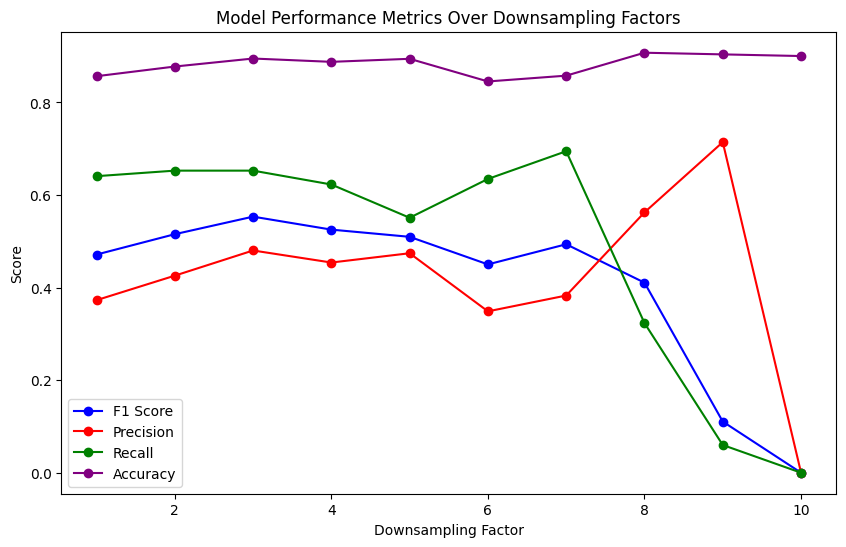

In [196]:
%pip install matplotlib
import matplotlib.pyplot as plt

downsampling_factors = [1,2,3,4,5,6,7,8,9,10]  # Adjust as per your case

# Creating a single figure for all plots
plt.figure(figsize=(10, 6))

# Plotting all scores on the same plot
plt.plot(downsampling_factors, f1_scores, marker='o', linestyle='-', color='blue', label='F1 Score')
plt.plot(downsampling_factors, precision_scores, marker='o', linestyle='-', color='red', label='Precision')
plt.plot(downsampling_factors, recall_scores, marker='o', linestyle='-', color='green', label='Recall')
plt.plot(downsampling_factors, accuracy_scores, marker='o', linestyle='-', color='purple', label='Accuracy')

# Adding titles and labels
plt.title('Model Performance Metrics Over Downsampling Factors')
plt.xlabel('Downsampling Factor')
plt.ylabel('Score')

# Adding legend
plt.legend()

plt.savefig('downsampling.png')  # You can specify a different file path and format (e.g., 'path/to/figure.pdf')


# Show plot
plt.show()

## Models with Upsampling

In [194]:
#downsample adv, noun, verb, adj synonyms
positive_examples = internal_train_set[internal_train_set['label'] == 1].shape[0]
negative_examples = internal_train_set[internal_train_set['label'] == 0].shape[0]
factor = int(negative_examples/positive_examples)

up_f1_scores = []
up_precision_scores = []
up_recall_scores = []
up_accuracy_scores = []

for factor in [1,2,3,4,5,6,7,8,9,10]:

    new_examples_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
    par_id = 77777
    new_rows_list = []

    for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
        for i in range(factor-1):
            new_row = row.copy()
            new_row['orig_id'] = row['par_id']
            new_row['par_id'] = par_id
            new_rows_list.append(pd.DataFrame([new_row]))
            par_id += 1
    
    if factor == 1:
        upsampled_internal_train_set = internal_train_set
    else:
        examples_df = pd.concat(new_rows_list, ignore_index=True).sample(frac=1, random_state=42)
        upsampled_internal_train_set = pd.concat([internal_train_set, examples_df.loc[:, examples_df.columns != 'orig_id']])

    #define model
    model_args = ClassificationArgs(num_train_epochs=3,
                                    no_save=False, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    use_multiprocessing=False,
                                    use_multiprocessing_for_evaluation=False,
                                    manual_seed=42,
                                    learning_rate=4e-5,
                                    logging_steps=1,
                                    save_eval_checkpoints=True,
                                    evaluate_during_training=True,
                                    evaluate_during_training_steps=50,
                                    use_early_stopping=False,
                                    early_stopping_metric = "f1_score",
                                    early_stopping_metric_minimize=False,
                                    early_stopping_patience=10,
                                    early_stopping_delta=0.0001,
                                    do_lower_case=True,
                                    best_model_dir='best_model/model_upsampling/',
                                    #wandb_project = "model_2",
                                    )
    model = ClassificationModel("roberta", 
                                    'roberta-base', 
                                    args = model_args, 
                                    num_labels=2, 
                                    use_cuda=True)
    # train model
    model.train_model(upsampled_internal_train_set[['text', 'label']], eval_df=internal_dev_set[['text','label']])

    # load best model
    model = ClassificationModel(
        "roberta",
        'best_model/model_upsampling/',
        num_labels=2,
        use_cuda=True  # Set to False if you're not using a GPU
    )
    # eval
    preds, _ = model.predict(internal_dev_set.text.tolist())
    labels = internal_dev_set.label.tolist()

    print(f'\n Metrics for positive example upsampling with factor {factor}')
    f1 = sklearn.metrics.f1_score(labels, preds)
    print(f1)
    acc = sklearn.metrics.accuracy_score(labels, preds)
    print(acc)
    rec = sklearn.metrics.recall_score(labels, preds)
    print(rec)
    prec = sklearn.metrics.precision_score(labels, preds)
    print(prec)
    print(sklearn.metrics.confusion_matrix(labels, preds))

    up_f1_scores.append(f1)
    up_recall_scores.append(rec)
    up_precision_scores.append(prec)
    up_accuracy_scores.append(acc)
    print(f'\n')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/838 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/838 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/838 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 1
0.0
0.9002985074626866
0.0
0.0
[[1508    0]
 [ 167    0]]




/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classificatio

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 2
0.5333333333333333
0.9080597014925373
0.5269461077844312
0.5398773006134969
[[1433   75]
 [  79   88]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/995 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/995 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/995 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 3
0.5188470066518847
0.8704477611940299
0.7005988023952096
0.4119718309859155
[[1341  167]
 [  50  117]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1073 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1073 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1073 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 4
0.5379310344827586
0.88
0.7005988023952096
0.43656716417910446
[[1357  151]
 [  50  117]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1151 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1151 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1151 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 5
0.5549738219895288
0.8985074626865671
0.6347305389221557
0.4930232558139535
[[1399  109]
 [  61  106]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1230 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1230 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1230 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 6
0.5670731707317073
0.9152238805970149
0.5568862275449101
0.577639751552795
[[1440   68]
 [  74   93]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1308 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1308 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1308 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 7
0.5471698113207547
0.9140298507462686
0.5209580838323353
0.5761589403973509
[[1444   64]
 [  80   87]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 8
0.5747126436781609
0.9116417910447762
0.5988023952095808
0.5524861878453039
[[1427   81]
 [  67  100]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1465 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1465 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1465 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 9
0.5609065155807366
0.9074626865671642
0.592814371257485
0.532258064516129
[[1421   87]
 [  68   99]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1543 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1543 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1543 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for positive example upsampling with factor 10
0.5519125683060109
0.9020895522388059
0.6047904191616766
0.507537688442211
[[1410   98]
 [  66  101]]




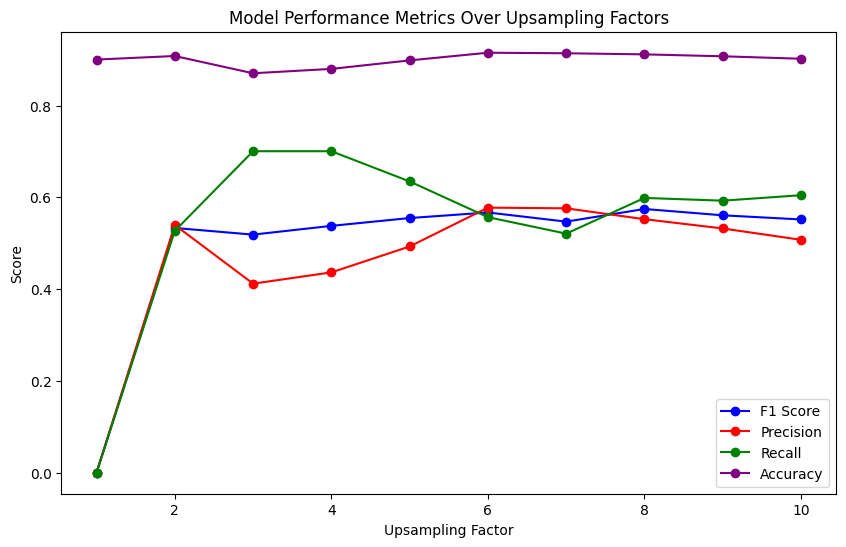

In [197]:
upsampling_factors = [1,2,3,4,5,6,7,8,9,10]  # Adjust as per your case

# Creating a single figure for all plots
plt.figure(figsize=(10, 6))

# Plotting all scores on the same plot
plt.plot(upsampling_factors, up_f1_scores, marker='o', linestyle='-', color='blue', label='F1 Score')
plt.plot(upsampling_factors, up_precision_scores, marker='o', linestyle='-', color='red', label='Precision')
plt.plot(upsampling_factors, up_recall_scores, marker='o', linestyle='-', color='green', label='Recall')
plt.plot(upsampling_factors, up_accuracy_scores, marker='o', linestyle='-', color='purple', label='Accuracy')

# Adding titles and labels
plt.title('Model Performance Metrics Over Upsampling Factors')
plt.xlabel('Upsampling Factor')
plt.ylabel('Score')

# Adding legend
plt.legend()

plt.savefig('upsampling.png')  # You can specify a different file path and format (e.g., 'path/to/figure.pdf')

# Show plot
plt.show()

## Models with WordNet Upsampling

In [51]:
#define synomimizer
def get_wordnet_pos(treebank_tag):
    """Converts treebank tags to WordNet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def synonymize_text(text, n=1, pos_list=[]):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    synonymized_tokens = []
    for word, pos in pos_tags:
        wn_pos = get_wordnet_pos(pos)
        synonyms = []
        
        if wn_pos in pos_list:  # Check if the POS is NOUN
            synsets = wordnet.synsets(word, pos=wn_pos)
            for synset in synsets:
                for lemma in synset.lemmas():
                    if lemma.name() not in synonyms:
                        synonyms.append(lemma.name())
                    if len(synonyms) >= n:
                        break
                if len(synonyms) >= n:
                    break
            
            if synonyms:  # If there are any synonyms
                selected_synonym = random.choice(synonyms[:n]) if len(synonyms) >= n else random.choice(synonyms)
                synonymized_tokens.append(selected_synonym.replace('_', ' '))  # Replace underscores for multi-word expressions
            else:
                synonymized_tokens.append(word)  # If no synonyms, keep the original word
        else:
            synonymized_tokens.append(word)  # Append the original word if it's not a noun
    
    return ' '.join(synonymized_tokens)

In [200]:
#downsample adv, noun, verb, adj synonyms
positive_examples = internal_train_set[internal_train_set['label'] == 1].shape[0]
negative_examples = internal_train_set[internal_train_set['label'] == 0].shape[0]
factor = int(negative_examples/positive_examples)

type_list = ['adjective', 'verb', 'noun', 'adv']

for name, type in zip(type_list, [[wordnet.ADJ], [wordnet.VERB], [wordnet.NOUN], [wordnet.ADV], [wordnet.NOUN, wordnet.ADV]]):
  new_examples_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
  par_id = 77777
  new_rows_list = []

  for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
      for i in range(1):
          new_text = synonymize_text(row['text'], n=1, pos_list=type)
          new_row = row.copy()
          new_row['text'] = new_text
          new_row['orig_id'] = row['par_id']
          new_row['par_id'] = par_id
          new_rows_list.append(pd.DataFrame([new_row]))
          par_id += 1

  examples_df = pd.concat(new_rows_list, ignore_index=True).sample(frac=1, random_state=42)
  upsampled_internal_train_set = pd.concat([internal_train_set, examples_df.loc[:, examples_df.columns != 'orig_id']])

  # downsample negative instances to 2:1
  #downsampled = downsample(upsampled_internal_train_set, factor=2)

  #define model
  model_args = ClassificationArgs(num_train_epochs=3,
                                  no_save=False, 
                                  no_cache=True, 
                                  overwrite_output_dir=True,
                                  use_multiprocessing=False,
                                  use_multiprocessing_for_evaluation=False,
                                  manual_seed=42,
                                  learning_rate=4e-5,
                                  logging_steps=1,
                                  save_eval_checkpoints=True,
                                  evaluate_during_training=True,
                                  evaluate_during_training_steps=50,
                                  use_early_stopping=False,
                                  early_stopping_metric = "f1_score",
                                  early_stopping_metric_minimize=False,
                                  early_stopping_patience=10,
                                  early_stopping_delta=0.0001,
                                  do_lower_case=True,
                                  best_model_dir='best_model/model_synonyms/',
                                  #wandb_project = "model_2",
                                  )
  model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = model_args, 
                                  num_labels=2, 
                                  use_cuda=True)
  # train model
  model.train_model(upsampled_internal_train_set[['text', 'label']], eval_df=internal_dev_set[['text','label']])

  # load best model
  model = ClassificationModel(
      "roberta",
      'best_model/model_synonyms/',
      num_labels=2,
      use_cuda=True  # Set to False if you're not using a GPU
  )
  # eval
  preds, _ = model.predict(internal_dev_set.text.tolist())
  labels = internal_dev_set.label.tolist()

  print(f'\n Metrics for type {name}')
  print(sklearn.metrics.f1_score(labels, preds))
  print(sklearn.metrics.accuracy_score(labels, preds))
  print(sklearn.metrics.recall_score(labels, preds))
  print(sklearn.metrics.precision_score(labels, preds))
  print(sklearn.metrics.confusion_matrix(labels, preds))
  print(f'\n')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for type adjective
0.536986301369863
0.8991044776119403
0.5868263473053892
0.494949494949495
[[1408  100]
 [  69   98]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for type verb
0.5348189415041783
0.9002985074626866
0.5748502994011976
0.5
[[1412   96]
 [  71   96]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for type noun
0.5659163987138264
0.9194029850746268
0.5269461077844312
0.6111111111111112
[[1452   56]
 [  79   88]]




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]


 Metrics for type adv
0.55625
0.9152238805970149
0.5329341317365269
0.5816993464052288
[[1444   64]
 [  78   89]]




## Model with Categorical Inclusion

In [55]:
from transformers import RobertaTokenizer

In [218]:
def preprocess_text_with_class(row, class_to_token, class_column_name):
    # Retrieve the appropriate token based on the class value
    cat_token = class_to_token.get(row[class_column_name], '')
    # Prepend the categorical token to the text
    return f"{cat_token} {row['text']}"

#upsample for comparibility
new_examples_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
par_id = 77777
new_rows_list = []
factor = 2

for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
    for i in range(factor-1):
        new_row = row.copy()
        new_row['orig_id'] = row['par_id']
        new_row['par_id'] = par_id
        new_rows_list.append(pd.DataFrame([new_row]))
        par_id += 1

if factor == 1:
    upsampled_internal_train_set = internal_train_set
else:
    examples_df = pd.concat(new_rows_list, ignore_index=True).sample(frac=1, random_state=42)
    upsampled_internal_train_set = pd.concat([internal_train_set, examples_df.loc[:, examples_df.columns != 'orig_id']])


augmented_internal_train_set = upsampled_internal_train_set.copy()
augmented_internal_dev_set = internal_dev_set.copy()
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
for class_column_name in ['community']:
    unique_classes = augmented_internal_train_set[class_column_name].unique()
    # Generate a unique token for each class
    class_to_token = {x: f"[{x.upper()}]" for x in unique_classes}

    # Add these tokens to the tokenizer
    num_added_toks = tokenizer.add_tokens(list(class_to_token.values()))

    #add cat column to train and dev
    augmented_internal_train_set['text'] = augmented_internal_train_set.apply(preprocess_text_with_class, axis=1, class_to_token=class_to_token, class_column_name=class_column_name)
    augmented_internal_dev_set['text'] = augmented_internal_dev_set.apply(preprocess_text_with_class, axis=1, class_to_token=class_to_token, class_column_name=class_column_name)


In [224]:

#define model
model_args = ClassificationArgs(num_train_epochs=3,
                                no_save=False, 
                                no_cache=True, 
                                overwrite_output_dir=True,
                                use_multiprocessing=False,
                                use_multiprocessing_for_evaluation=False,
                                manual_seed=42,
                                learning_rate=4e-5,
                                logging_steps=1,
                                save_eval_checkpoints=True,
                                evaluate_during_training=True,
                                evaluate_during_training_steps=50,
                                use_early_stopping=False,
                                early_stopping_metric = "f1_score",
                                early_stopping_metric_minimize=False,
                                early_stopping_patience=10,
                                early_stopping_delta=0.0001,
                                do_lower_case=False,
                                best_model_dir='best_model/model_token/',
                                #wandb_project = "model_2",
                                )
model = ClassificationModel("roberta", 
                                'roberta-base', 
                                args = model_args, 
                                num_labels=2, 
                                use_cuda=True)
# train model
model.tokenizer = tokenizer
model.model.resize_token_embeddings(len(tokenizer))
model.train_model(augmented_internal_train_set[['text', 'label']], eval_df=augmented_internal_dev_set[['text','label']])

# load best model
model = ClassificationModel(
    "roberta",
    'best_model/model_token/',
    num_labels=2,
    use_cuda=True  # Set to False if you're not using a GPU
)
# eval
preds, _ = model.predict(augmented_internal_dev_set.text.tolist())
labels = augmented_internal_dev_set.label.tolist()

print(f'metrics for including class {class_column_name}')
print(sklearn.metrics.f1_score(labels, preds))
print(sklearn.metrics.accuracy_score(labels, preds))
print(sklearn.metrics.recall_score(labels, preds))
print(sklearn.metrics.precision_score(labels, preds))
print(sklearn.metrics.confusion_matrix(labels, preds))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

metrics for including class community
0.5395894428152492
0.9062686567164179
0.5508982035928144
0.5287356321839081
[[1426   82]
 [  75   92]]


## Model with Backtranslation

In [230]:
from transformers import MarianMTModel, MarianTokenizer
from nltk.tokenize import sent_tokenize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the EN-FR model 
EF_model_name = 'Helsinki-NLP/opus-mt-en-fr'
EF_tokenizer = MarianTokenizer.from_pretrained(EF_model_name)
EF_model = MarianMTModel.from_pretrained(EF_model_name).to(device)

# Load the FR-EN model 
FE_model_name = 'Helsinki-NLP/opus-mt-fr-en'
FE_tokenizer = MarianTokenizer.from_pretrained(FE_model_name)
FE_model = MarianMTModel.from_pretrained(FE_model_name).to(device)

#retranslate sentences
positive_examples = internal_train_set[internal_train_set['label'] == 1].shape[0]
negative_examples = internal_train_set[internal_train_set['label'] == 0].shape[0]
factor = int(negative_examples/positive_examples)

new_examples_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
par_id = 77777
new_rows_list = []

#truncate function to avoid out of bounds in trasnformer
def truncate_text(text, max_length=512):
    tokens = EF_tokenizer.tokenize(text)
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    truncated_text = EF_tokenizer.convert_tokens_to_string(tokens)
    return truncated_text

#split -> translate -> retranslate -> concat
def split_translate_retranslate_concat(text, en_tokenizer, de_tokenizer, en_model, de_model):
    sentences = sent_tokenize(text)
    retranslated_sentences = []
    for sentence in sentences:
        # Check if individual sentences need to be truncated
        truncated_sentence = truncate_text(sentence, max_length=510)  # leave some space for special tokens
        translated = en_model.generate(**en_tokenizer(truncated_sentence, return_tensors="pt", padding=True).to(device))
        FR_text= en_tokenizer.decode(translated[0], skip_special_tokens=True)
        translated = de_model.generate(**de_tokenizer(FR_text, return_tensors="pt", padding=True).to(device))
        retranslated_sentence = de_tokenizer.decode(translated[0], skip_special_tokens=True)
        retranslated_sentences.append(retranslated_sentence)
    return " ".join(retranslated_sentences)

for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
    for i in range(1):
        new_text = split_translate_retranslate_concat(row['text'], EF_tokenizer, FE_tokenizer, EF_model, FE_model)
        new_row = row.copy()
        new_row['text'] = new_text
        new_row['orig_id'] = row['par_id']
        new_row['par_id'] = par_id
        new_rows_list.append(pd.DataFrame([new_row]))
        par_id += 1

examples_df = pd.concat(new_rows_list, ignore_index=True)
upsampled_internal_train_set = pd.concat([internal_train_set, examples_df.loc[:, examples_df.columns != 'orig_id']])


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [213]:
#model with back-translation
model_args = ClassificationArgs(num_train_epochs=3,
                                no_save=False, 
                                no_cache=True, 
                                overwrite_output_dir=True,
                                use_multiprocessing=False,
                                use_multiprocessing_for_evaluation=False,
                                manual_seed=42,
                                learning_rate=4e-5,
                                logging_steps=1,
                                save_eval_checkpoints=True,
                                evaluate_during_training=True,
                                evaluate_during_training_steps=50,
                                use_early_stopping=False,
                                early_stopping_metric = "f1_score",
                                early_stopping_metric_minimize=False,
                                early_stopping_patience=10,
                                early_stopping_delta=0.0001,
                                do_lower_case=True,
                                best_model_dir='best_model/back-translation/',
                                #wandb_project = "model_2",
                                )
model = ClassificationModel("roberta", 
                                'roberta-base', 
                                args = model_args, 
                                num_labels=2, 
                                use_cuda=True)
# train model
model.train_model(upsampled_internal_train_set[['text', 'label']], eval_df=internal_dev_set[['text','label']])

# load best model
model = ClassificationModel(
    "roberta",
    'best_model/back-translation/',
    num_labels=2,
    use_cuda=True  # Set to False if you're not using a GPU
)
# eval
preds, _ = model.predict(internal_dev_set.text.tolist())
labels = internal_dev_set.label.tolist()

print(sklearn.metrics.f1_score(labels, preds))
print(sklearn.metrics.accuracy_score(labels, preds))
print(sklearn.metrics.recall_score(labels, preds))
print(sklearn.metrics.precision_score(labels, preds))
print(sklearn.metrics.confusion_matrix(labels, preds))
print(f'\n')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/916 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

0.5369127516778524
0.9176119402985075
0.47904191616766467
0.6106870229007634
[[1457   51]
 [  87   80]]




## Basic Comparison Model (plus baseline roberta)

In [333]:
#BAG OF WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Convert text documents to a matrix of token counts
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(internal_train_set['text'])
X_test_counts = vectorizer.transform(internal_dev_set['text'])

# Train a Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_counts, internal_train_set['label'])

# Make predictions and evaluate the model
labels = internal_dev_set['label']
preds = classifier.predict(X_test_counts)

predicted_internal_dev_set = internal_dev_set.copy()
predicted_internal_dev_set['preds'] = preds

print(sklearn.metrics.f1_score(labels, preds))
print(sklearn.metrics.accuracy_score(labels, preds))
print(sklearn.metrics.recall_score(labels, preds))
print(sklearn.metrics.precision_score(labels, preds))
print(sklearn.metrics.confusion_matrix(labels, preds))
print(f'\n')

#predicted_internal_dev_set[(predicted_internal_dev_set['preds']==0) & (predicted_internal_dev_set['label']==1)].iloc[0]
predicted_internal_dev_set[(predicted_internal_dev_set['preds']==0) & (predicted_internal_dev_set['label']==1)]['text'].iloc[0]

0.3217391304347826
0.906865671641791
0.2215568862275449
0.5873015873015873
[[1482   26]
 [ 130   37]]




'""" Very often , the people who are most in need may not read the newspapers , access the Internet or even understand English , "" he told parliament last month . "" They need people who can talk to them in their language , people who will knock on their doors , check on them to see whether they are okay , and explain some of these assistance schemes to them . """'

In [157]:
#Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(internal_train_set['text'], internal_train_set['label'])

# Make predictions and evaluate the model
labels = internal_dev_set['label']
preds = model.predict(internal_dev_set['text'])

print(sklearn.metrics.f1_score(labels, preds))
print(sklearn.metrics.accuracy_score(labels, preds))
print(sklearn.metrics.recall_score(labels, preds))
print(sklearn.metrics.precision_score(labels, preds))
print(sklearn.metrics.confusion_matrix(labels, preds))
print(f'\n')


0.023121387283236993
0.8991044776119403
0.011976047904191617
0.3333333333333333
[[1504    4]
 [ 165    2]]




### My Final Model

In [236]:
#prepare final data (with and without categorical token)

#synonym replacement
type_list = ['adjective', 'verb', 'noun', 'adv']
new_rows_list = []

artificial_examples_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
for name, type in zip(type_list, [[wordnet.ADJ], [wordnet.VERB], [wordnet.NOUN], [wordnet.ADV]]):
  par_id = 77777
  for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
      for i in range(1):
          new_text = synonymize_text(row['text'], n=1, pos_list=type)
          new_row = row.copy()
          new_row['text'] = new_text
          new_row['orig_id'] = row['par_id']
          new_row['replacement_type'] = row['par_id']
          new_row['par_id'] = par_id
          new_rows_list.append(pd.DataFrame([new_row]))
          par_id += 1
  
artificial_examples_df = pd.concat(new_rows_list, ignore_index=True).sample(frac=1, random_state=42)

#back-translation replacement
backtrans_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
new_rows_list = []
for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
    for i in range(1):
        new_text = split_translate_retranslate_concat(row['text'], EF_tokenizer, FE_tokenizer, EF_model, FE_model)
        new_row = row.copy()
        new_row['text'] = new_text
        new_row['orig_id'] = row['par_id']
        new_row['par_id'] = par_id
        new_rows_list.append(pd.DataFrame([new_row]))
        par_id += 1

backtrans_df = pd.concat(new_rows_list, ignore_index=True)

#upsample original 2 times
upsample_df = pd.DataFrame(columns= list(internal_train_set.columns) + ['orig_id'])
new_rows_list = []
factor = 3

for index, row in internal_train_set[internal_train_set['label']==1].iterrows():
    for i in range(factor-1):
        new_row = row.copy()
        new_row['orig_id'] = row['par_id']
        new_row['par_id'] = par_id
        new_rows_list.append(pd.DataFrame([new_row]))
        par_id += 1

upsampled_df = pd.concat(new_rows_list, ignore_index=True)

#join
final_internal_train_set = pd.concat([internal_train_set, artificial_examples_df.loc[:, artificial_examples_df.columns != 'orig_id']])
final_internal_train_set = pd.concat([final_internal_train_set, backtrans_df.loc[:, backtrans_df.columns != 'orig_id']])
final_internal_train_set = pd.concat([final_internal_train_set, upsampled_df.loc[:, upsampled_df.columns != 'orig_id']])

#shuffle
final_internal_train_set = final_internal_train_set.sample(frac=1, random_state=42)

aug_final_internal_train_set = final_internal_train_set.copy()
augmented_internal_dev_set = internal_dev_set.copy()

#categorical
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
for class_column_name in ['community']:
    unique_classes = augmented_internal_train_set[class_column_name].unique()
    # Generate a unique token for each class
    class_to_token = {x: f"[{x.upper()}]" for x in unique_classes}

    # Add these tokens to the tokenizer
    num_added_toks = tokenizer.add_tokens(list(class_to_token.values()))

    #add cat column to train and dev
    aug_final_internal_train_set['text'] = aug_final_internal_train_set.apply(preprocess_text_with_class, axis=1, class_to_token=class_to_token, class_column_name=class_column_name)
    augmented_internal_dev_set['text'] = augmented_internal_dev_set.apply(preprocess_text_with_class, axis=1, class_to_token=class_to_token, class_column_name=class_column_name)



In [270]:
#final model with categorical 
model_args = ClassificationArgs(num_train_epochs=3,
                                no_save=False, 
                                no_cache=True, 
                                overwrite_output_dir=True,
                                use_multiprocessing=False,
                                use_multiprocessing_for_evaluation=False,
                                manual_seed=42,
                                learning_rate=4e-5,
                                logging_steps=1,
                                save_eval_checkpoints=True,
                                evaluate_during_training=True,
                                evaluate_during_training_steps=50,
                                use_early_stopping=False,
                                early_stopping_metric = "f1_score",
                                early_stopping_metric_minimize=False,
                                early_stopping_patience=10,
                                early_stopping_delta=0.0001,
                                do_lower_case=True,
                                best_model_dir='best_model/final/',
                                #warmup_steps=100,  # Number of warmup steps for linear_schedule_with_warmup
                                #warmup_ratio=0.1,
                                #wandb_project = "model_2",
                                )
model = ClassificationModel("roberta", 
                                'roberta-base', 
                                args = model_args, 
                                num_labels=2, 
                                use_cuda=True)
# train model
model.tokenizer = tokenizer
model.model.resize_token_embeddings(len(tokenizer))
model.train_model(aug_final_internal_train_set[['text', 'label']], eval_df=augmented_internal_dev_set[['text','label']])

# load best model
model = ClassificationModel(
    "roberta",
    'best_model/final/',
    num_labels=2,
    use_cuda=True  # Set to False if you're not using a GPU
)
# eval
preds, _ = model.predict(augmented_internal_dev_set.text.tolist())
labels = augmented_internal_dev_set.label.tolist()

print(f'Final model metrics')
print(sklearn.metrics.f1_score(labels, preds))
print(sklearn.metrics.accuracy_score(labels, preds))
print(sklearn.metrics.recall_score(labels, preds))
print(sklearn.metrics.precision_score(labels, preds))
print(sklearn.metrics.confusion_matrix(labels, preds))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

Final model metrics
0.5696969696969697
0.9152238805970149
0.562874251497006
0.5766871165644172
[[1439   69]
 [  73   94]]


In [282]:
#final model without categorical
final_model_args = ClassificationArgs(num_train_epochs=3,
                                no_save=False, 
                                no_cache=True, 
                                overwrite_output_dir=True,
                                use_multiprocessing=False,
                                use_multiprocessing_for_evaluation=False,
                                manual_seed=42,
                                learning_rate=4e-5,
                                logging_steps=1,
                                save_eval_checkpoints=True,
                                evaluate_during_training=True,
                                evaluate_during_training_steps=50,
                                use_early_stopping=False,
                                early_stopping_metric = "f1_score",
                                early_stopping_metric_minimize=False,
                                early_stopping_patience=10,
                                early_stopping_delta=0.0001,
                                do_lower_case=True,
                                best_model_dir='best_model/final/',
                                )
final_model = ClassificationModel("roberta", 
                                'roberta-base', 
                                args = final_model_args, 
                                num_labels=2, 
                                use_cuda=True)
# train model
final_model.train_model(final_internal_train_set[['text', 'label']], eval_df=internal_dev_set[['text','label']])

# load best model
final_model = ClassificationModel(
    "roberta",
    'best_model/final/',
    num_labels=2,
    use_cuda=True  # Set to False if you're not using a GPU
)
# eval
preds, _ = final_model.predict(internal_dev_set.text.tolist())
labels = internal_dev_set.label.tolist()

print(f'Final model metrics')
print(sklearn.metrics.f1_score(labels, preds))
print(sklearn.metrics.accuracy_score(labels, preds))
print(sklearn.metrics.recall_score(labels, preds))
print(sklearn.metrics.precision_score(labels, preds))
print(sklearn.metrics.confusion_matrix(labels, preds))


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

Final model metrics
0.5804597701149425
0.9128358208955224
0.6047904191616766
0.5580110497237569
[[1428   80]
 [  66  101]]


## Final Predictions

### Official Dev Set

In [344]:
#predictions on official dev set
final_preds, _ = final_model.predict(tedf1.text.tolist())
labels = tedf1.label.tolist()

print(f'Final model metrics')
print(sklearn.metrics.f1_score(labels, final_preds))
print(sklearn.metrics.accuracy_score(labels, final_preds))
print(sklearn.metrics.recall_score(labels, final_preds))
print(sklearn.metrics.precision_score(labels, final_preds))
print(sklearn.metrics.confusion_matrix(labels, final_preds))

labels2file([[k] for k in final_preds], './dev.txt')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/21 [00:00<?, ?it/s]

Final model metrics
0.5213270142180095
0.9035339063992359
0.5527638190954773
0.49327354260089684
[[1782  113]
 [  89  110]]


### Official Test Set

In [343]:
#predictions on official test set
final_preds_test, _ = final_model.predict(test.text.tolist())

labels2file([[k] for k in final_preds_test], './test.txt')


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/39 [00:00<?, ?it/s]

In [340]:
final_preds_test

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## Hyperparameter Search

In [259]:
%pip install optuna

import optuna

def objective(trial):
    lr = trial.suggest_float('lr', 4e-6, 4e-4)
    case = trial.suggest_categorical('case', [True, False])
    schedule = trial.suggest_categorical('schedule', ['linear_schedule_with_warmup', 'constant_schedule'])
 s
    #define model
    model_args = ClassificationArgs(num_train_epochs=3,
                                    no_save=False, 
                                    no_cache=True, 
                                    overwrite_output_dir=True,
                                    use_multiprocessing=False,
                                    use_multiprocessing_for_evaluation=False,
                                    manual_seed=42,
                                    learning_rate=lr,
                                    logging_steps=1,
                                    save_eval_checkpoints=True,
                                    evaluate_during_training=True,
                                    evaluate_during_training_steps=50,
                                    use_early_stopping=False,
                                    early_stopping_metric = "f1_score",
                                    early_stopping_metric_minimize=False,
                                    early_stopping_patience=10,
                                    early_stopping_delta=0.0001,
                                    do_lower_case=case,
                                    best_model_dir='best_model/final/',
                                    scheduler=schedule,
                                    )
    model = ClassificationModel("roberta", 
                                    'roberta-base', 
                                    args = model_args, 
                                    num_labels=2, 
                                    use_cuda=True)

    model.train_model(final_internal_train_set[['text', 'label']], eval_df=internal_dev_set[['text','label']])

    # load best model
    model = ClassificationModel(
        "roberta",
        'best_model/final/',
        num_labels=2,
        use_cuda=True  # Set to False if you're not using a GPU
    )
    # eval
    preds, _ = model.predict(internal_dev_set.text.tolist())
    labels = internal_dev_set.label.tolist()

    print(f'Final model metrics')
    f1 = sklearn.metrics.f1_score(labels, preds)
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

study.best_params


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


[I 2024-03-05 03:51:38,058] A new study created in memory with name: no-name-7b7200cc-5717-40c2-bac7-2d9af53a9513


Note: you may need to restart the kernel to use updated packages.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 04:05:06,406] Trial 0 finished with value: 0.25494853523357086 and parameters: {'lr': 0.00038699084201502317, 'case': True, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 0 with value: 0.25494853523357086.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 04:18:13,152] Trial 1 finished with value: 0.18132464712269272 and parameters: {'lr': 0.00025910917000230774, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 0 with value: 0.25494853523357086.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 04:31:23,572] Trial 2 finished with value: 0.18132464712269272 and parameters: {'lr': 0.00017890444894546177, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 0 with value: 0.25494853523357086.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 04:44:34,052] Trial 3 finished with value: 0.4288577154308617 and parameters: {'lr': 0.00020092079440665203, 'case': False, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 3 with value: 0.4288577154308617.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 04:57:47,572] Trial 4 finished with value: 0.4317343173431734 and parameters: {'lr': 0.00024354895765922515, 'case': False, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 4 with value: 0.4317343173431734.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 05:11:02,581] Trial 5 finished with value: 0.46473029045643155 and parameters: {'lr': 0.00014031008148145937, 'case': True, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 5 with value: 0.46473029045643155.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 05:24:17,537] Trial 6 finished with value: 0.4165232358003442 and parameters: {'lr': 0.00015481341600278358, 'case': True, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 5 with value: 0.46473029045643155.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 05:37:28,917] Trial 7 finished with value: 0.18132464712269272 and parameters: {'lr': 0.000235483784585622, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 5 with value: 0.46473029045643155.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 05:51:20,367] Trial 8 finished with value: 0.4689922480620155 and parameters: {'lr': 0.00016975783874595372, 'case': False, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 8 with value: 0.4689922480620155.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 06:04:59,710] Trial 9 finished with value: 0.2764654418197725 and parameters: {'lr': 0.00036453174729402904, 'case': True, 'schedule': 'linear_schedule_with_warmup'}. Best is trial 8 with value: 0.4689922480620155.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 06:19:02,410] Trial 10 finished with value: 0.5714285714285714 and parameters: {'lr': 2.3533151546198665e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 06:32:15,578] Trial 11 finished with value: 0.546916890080429 and parameters: {'lr': 2.9312100430422543e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 06:46:14,178] Trial 12 finished with value: 0.5444126074498568 and parameters: {'lr': 3.3912013758952565e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 07:00:06,221] Trial 13 finished with value: 0.5358090185676393 and parameters: {'lr': 1.7368978715694847e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 07:13:12,997] Trial 14 finished with value: 0.18132464712269272 and parameters: {'lr': 8.493973381042014e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 07:26:24,560] Trial 15 finished with value: 0.18132464712269272 and parameters: {'lr': 9.449048194715571e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 07:39:43,428] Trial 16 finished with value: 0.4585365853658537 and parameters: {'lr': 6.52414600905426e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 07:52:49,728] Trial 17 finished with value: 0.5513513513513514 and parameters: {'lr': 1.2451923667622861e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 08:06:02,978] Trial 18 finished with value: 0.18132464712269272 and parameters: {'lr': 0.0003064054655512047, 'case': True, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 08:19:19,843] Trial 19 finished with value: 0.18132464712269272 and parameters: {'lr': 0.0001198273043878995, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 08:32:47,665] Trial 20 finished with value: 0.18132464712269272 and parameters: {'lr': 5.0220090777546115e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 08:47:03,020] Trial 21 finished with value: 0.5604395604395604 and parameters: {'lr': 8.264446388939526e-06, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 09:01:05,287] Trial 22 finished with value: 0.5555555555555556 and parameters: {'lr': 8.918627885581984e-06, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 09:14:30,764] Trial 23 finished with value: 0.18132464712269272 and parameters: {'lr': 9.784832560778846e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 09:28:42,243] Trial 24 finished with value: 0.5630026809651475 and parameters: {'lr': 6.138832754895584e-06, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 09:42:02,655] Trial 25 finished with value: 0.46 and parameters: {'lr': 6.918049461549496e-05, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 09:56:09,212] Trial 26 finished with value: 0.456575682382134 and parameters: {'lr': 5.1582620546585954e-05, 'case': True, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 10:10:08,488] Trial 27 finished with value: 0.18132464712269272 and parameters: {'lr': 0.00012347717110955338, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 10 with value: 0.5714285714285714.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 10:24:56,181] Trial 28 finished with value: 0.584070796460177 and parameters: {'lr': 4.2095997406595945e-06, 'case': False, 'schedule': 'constant_schedule'}. Best is trial 28 with value: 0.584070796460177.


Final model metrics


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 2 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

Running Epoch 3 of 3:   0%|          | 0/1387 [00:00<?, ?it/s]

/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warni

  0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-03-05 10:38:50,284] Trial 29 finished with value: 0.5633802816901409 and parameters: {'lr': 3.927073074565867e-05, 'case': True, 'schedule': 'constant_schedule'}. Best is trial 28 with value: 0.584070796460177.


Final model metrics


{'lr': 4.2095997406595945e-06, 'case': False, 'schedule': 'constant_schedule'}

## Analysis

In [296]:
#filter by original label
orig_label_f1_scores = []
orig_label_acc_scores = []
orig_label_rec_scores = []
orig_label_prec_scores = []

final_preds_df = pd.DataFrame(final_preds, columns=['pred'])

for orig_label in [0,1,2,3,4]:
    cut_preds = final_preds_df[tedf1['orig_label']==orig_label].pred.tolist()
    cut_labels = tedf1[tedf1['orig_label']==orig_label].label.tolist()

    print(f'Metrics for original label {orig_label}')
    print(sklearn.metrics.f1_score(cut_labels, cut_preds))
    print(sklearn.metrics.accuracy_score(cut_labels, cut_preds))
    print(sklearn.metrics.recall_score(cut_labels, cut_preds))
    print(sklearn.metrics.precision_score(cut_labels, cut_preds))
    orig_label_f1_scores.append(f1)
    orig_label_acc_scores.append(acc)
    orig_label_rec_scores.append(rec)
    orig_label_prec_scores.append(prec)

Metrics for original label 0
0.0
0.954225352112676
0.0
0.0
Metrics for original label 1
0.0
0.8167539267015707
0.0
0.0
Metrics for original label 2
0.36363636363636365
0.2222222222222222
0.2222222222222222
1.0
Metrics for original label 3
0.6515151515151515
0.48314606741573035
0.48314606741573035
1.0
Metrics for original label 4
0.8129032258064516
0.6847826086956522
0.6847826086956522
1.0


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [303]:
#filter by input length
word_count_f1_scores = []
word_count_acc_scores = []
word_count_rec_scores = []
word_count_prec_scores = []

max = tedf1['word_count'].max()
print(max)

for step in list(range(0, 280, 20)):
    cut_preds = final_preds_df[(tedf1['word_count']>=step) & (tedf1['word_count']<step+10)].pred.tolist()
    cut_labels = tedf1[(tedf1['word_count']>=step) & (tedf1['word_count']<step+10)].label.tolist()

    print(f'Metrics for {step}, {step}+20')
    f1 = sklearn.metrics.f1_score(cut_labels, cut_preds)
    print(f1)
    acc = sklearn.metrics.accuracy_score(cut_labels, cut_preds)
    print(acc)
    rec = sklearn.metrics.recall_score(cut_labels, cut_preds)
    print(rec)
    prec = sklearn.metrics.precision_score(cut_labels, cut_preds)
    print(prec)
    word_count_f1_scores.append(f1)
    word_count_acc_scores.append(acc)
    word_count_rec_scores.append(rec)
    word_count_prec_scores.append(prec)

272
Metrics for 0, 0+20
0.0
0.9393939393939394
0.0
0.0
Metrics for 20, 20+20
0.5581395348837209
0.9457142857142857
0.631578947368421
0.5
Metrics for 40, 40+20
0.5555555555555556
0.9123287671232877
0.6896551724137931
0.46511627906976744
Metrics for 60, 60+20
0.42105263157894735
0.8523489932885906
0.4444444444444444
0.4
Metrics for 80, 80+20
0.5263157894736842
0.881578947368421
0.45454545454545453
0.625
Metrics for 100, 100+20
0.5454545454545454
0.875
0.6
0.5
Metrics for 120, 120+20
0.6666666666666666
0.875
0.5
1.0
Metrics for 140, 140+20
0.5
0.8
1.0
0.3333333333333333
Metrics for 160, 160+20
1.0
1.0
1.0
1.0
Metrics for 180, 180+20
0.0
1.0
0.0
0.0
Metrics for 200, 200+20
0.0
nan
0.0
0.0
Metrics for 220, 220+20
0.0
nan
0.0
0.0
Metrics for 240, 240+20
0.0
nan
0.0
0.0
Metrics for 260, 260+20
0.0
nan
0.0
0.0


/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/meh23/nlp_coursework/.myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

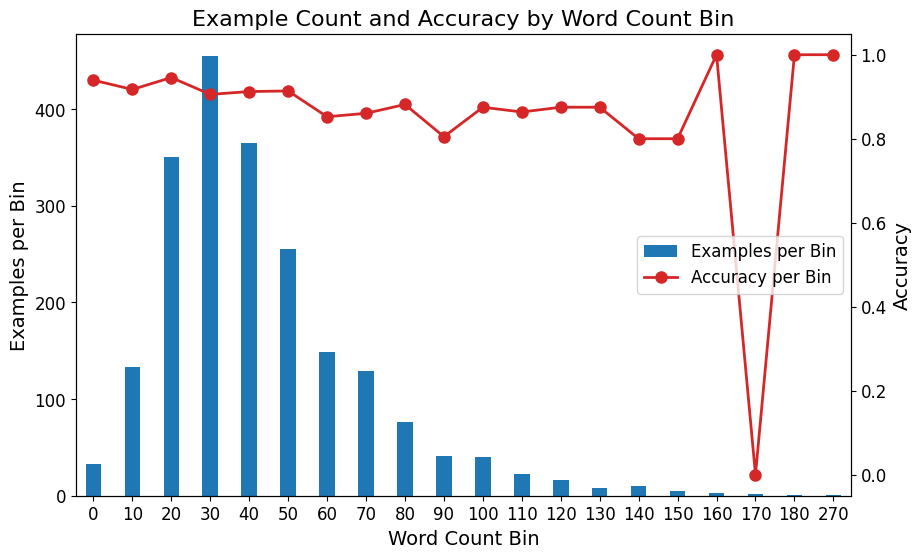

In [332]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming tedf1 is your DataFrame that includes 'label', 'preds', 'word_count', and the calculated 'correct'
tedf1['preds'] = final_preds_df
tedf1['correct'] = tedf1['label'] == tedf1['preds']


# Creating bins for word count
bin_size = 10
tedf1['word_count_bin'] = (tedf1['word_count'] // bin_size) * bin_size

# Calculate the ratio of correct classifications within each bin for all examples
ratio_of_correct_all = tedf1.groupby('word_count_bin')['correct'].mean()

# Count the total number of examples in each bin
count_of_all = tedf1.groupby('word_count_bin').size()

# Setting up the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the count of all examples as bars
count_of_all.plot(kind='bar', color='tab:blue', width=0.4, label='Examples per Bin', ax=ax1)
ax1.set_xlabel('Word Count Bin', fontsize=14)
ax1.set_ylabel('Examples per Bin', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

# Ensure the x-ticks are aligned with the bars for proper visualization
ax1.set_xticks(range(len(count_of_all)))
ax1.set_xticklabels([f'{bin}' for bin in count_of_all.index], rotation=0, fontsize=12)

# Create a secondary axis for the ratio of correct classifications
ax2 = ax1.twinx()
# Plotting the ratio of correct classifications as a line
# The x-coordinates for the line plot are aligned with the bars
ax2.plot(ax1.get_xticks(), ratio_of_correct_all, color='tab:red', marker='o', linestyle='-', linewidth=2, markersize=8, label='Accuracy per Bin')
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)

# Adding legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='center right', fontsize=12)

plt.title('Example Count and Accuracy by Word Count Bin', fontsize=16)
plt.show()


In [328]:
#filter by community
community_f1_scores = {}
community_acc_scores = {}
community_rec_scores = {}
community_prec_scores = {}
counts = {}

for category in communities:
    cut_preds = final_preds_df[(tedf1['community']==category)].pred.tolist()
    cut_labels = tedf1[(tedf1['community']==category)].label.tolist()
    count = len(final_preds_df[(tedf1['community']==category)].pred.tolist())
    counts[category] = count

    f1 = sklearn.metrics.f1_score(cut_labels, cut_preds)
    acc =sklearn.metrics.accuracy_score(cut_labels, cut_preds)
    rec = sklearn.metrics.recall_score(cut_labels, cut_preds)
    prec = sklearn.metrics.precision_score(cut_labels, cut_preds)
    community_f1_scores[category]=f1
    community_acc_scores[category]=acc
    community_rec_scores[category]=rec
    community_prec_scores[category]=prec

print(community_f1_scores)
print(counts)

{'hopeless': 0.509090909090909, 'migrant': 0.3076923076923077, 'immigrant': 0.3333333333333333, 'disabled': 0.48484848484848486, 'refugee': 0.4666666666666667, 'in-need': 0.7631578947368421, 'homeless': 0.4126984126984127, 'vulnerable': 0.5333333333333333, 'women': 0.4, 'poor-families': 0.5066666666666667}
{'hopeless': 217, 'migrant': 207, 'immigrant': 218, 'disabled': 194, 'refugee': 188, 'in-need': 226, 'homeless': 212, 'vulnerable': 209, 'women': 233, 'poor-families': 190}
